
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/home/ubuntu/mmdet1024/input"


In [2]:
pwd

'/home/ubuntu/mmdet1024'

In [3]:
os.makedirs('./input', exist_ok=True)
os.makedirs('./output', exist_ok=True)
%cd input

/home/ubuntu/mmdet1024/input


In [4]:
cd /home/ubuntu/mmdet1024/input

/home/ubuntu/mmdet1024/input


In [5]:
df = pd.read_csv('./train.csv')
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

,image_id,class_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,4,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,1,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,12,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,6,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,11,240.0,1550.0,562.0,2001.0
67906,26d1d5a0ef2e692c6340e74859ffdc53,14,1163.0,787.0,1338.0,941.0
67907,22672ab82c290c20b86863291e25ef6c,6,299.0,664.0,794.0,1508.0
67908,db169d0be36123bd55b866d6aa73983b,10,6.0,670.0,272.0,1736.0


In [6]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    # images
    res['images'].append({
        'id': pic_name,
        'width': 1024,
        'height': 1024,
        'file_name': pic_name+".png"
    })
    
    # annotations
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
# categories    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [7]:
random.seed(10)

# train_files = glob(os.path.join(base_dir, 'train/*.png'))
# train_files = os.listdir('./input/train')
# train_files = list(map(del_extension, train_files))
train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [8]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [9]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [10]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [11]:
!pip show torch

Name: torch
Version: 1.10.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages
Requires: typing_extensions
Required-by: timm, torchaudio, torchvision


런타임 다시 시작하고 진행합니다.

In [12]:
%cd ../

/home/ubuntu/mmdet1024


In [13]:
!git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [14]:
%cd ./mmdetection

/home/ubuntu/mmdet1024/mmdetection


=========

In [15]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0 True
2.25.2
11.3
GCC 9.3


In [16]:
pwd

'/home/ubuntu/mmdet1024/mmdetection'

In [17]:
# %cd mmdetection
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
#       -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

# %cd mmdetection
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
      -O checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-10-25 06:32:50--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.43
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.43|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [29]:
# Choose to use a config and initialize the detector
config = "/home/ubuntu/mmdet1024/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"
# Setup a checkpoint file to load
checkpoint = '/home/ubuntu/mmdet1024/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# initialize the detector
#model = init_detector(config, checkpoint, device='cuda:0')

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [30]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [31]:
from mmcv import Config
cfg = Config.fromfile(config)

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [32]:
from mmdet.apis import set_random_seed

base_path = '/home/ubuntu/mmdet1024/input' 
%cd '/home/ubuntu/mmdet1024/input'

/home/ubuntu/mmdet1024/input


In [33]:
save_dir = os.path.join(base_path, "work_dir")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_dir

'/home/ubuntu/mmdet1024/input/work_dir'

In [37]:
EPOCHS = 20
cfg.work_dir = save_dir+'/faster/1'

val_anno = "valid_annotations.json"  
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"

# 이미지 폴더 설정
train_img = "train" # 출력은 "train_100000"
val_img = 'train'
test_img =  "test"


# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = val_anno
cfg.data.val.img_prefix = val_img

# test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img


cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis'
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint # Error가 날 경우, "/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"

################################################################ 파인튜닝 , 재학습, transfer learning(전이학습) ################################################################
################################################################ 링크 파일 역할, training 조사 ################################################################

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
optimizer = dict(type='Adam', lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
#cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

# 10개씩 잘라서 학습.. 미니배치 느낌이랄까?
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [38]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 759   | 1 [Atelectasis]         | 118   | 2 [Calcification] | 144   | 3 [Cardiomegaly]        | 67    | 4 [Consolidation] | 159   |
| 5 [ILD]                | 274   | 6 [Infiltration]        | 383   | 7 [Lung Opacity]  | 619   | 8 [Nodule/Mass]         | 425   | 9 [Other lesion]  | 510   |
| 10 [Pleural effusion]  | 179   | 11 [Pleur

In [39]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-25 06:49:34,436 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-25 06:49:34,460 - mmdet - INFO - load checkpoint from local path: /home/ubuntu/mmdet1024/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-10-25 06:49:34,543 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([56, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in 

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2022-10-25 06:49:42,486 - mmdet - INFO - Epoch [1][10/440]	lr: 2.000e-02, eta: 1:54:38, time: 0.783, data_time: 0.249, memory: 8792, loss_rpn_cls: 0.1399, loss_rpn_bbox: 0.0215, loss_cls: 0.4136, acc: 88.8550, loss_bbox: 0.0731, loss: 0.6482
2022-10-25 06:49:47,965 - mmdet - INFO - Epoch [1][20/440]	lr: 2.000e-02, eta: 1:37:20, time: 0.548, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0726, loss_rpn_bbox: 0.0173, loss_cls: 0.1716, acc: 97.7222, loss_bbox: 0.0842, loss: 0.3456
2022-10-25 06:49:53,455 - mmdet - INFO - Epoch [1][30/440]	lr: 2.000e-02, eta: 1:31:34, time: 0.549, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0645, loss_rpn_bbox: 0.0168, loss_cls: 0.1249, acc: 98.3887, loss_bbox: 0.0588, loss: 0.2650
2022-10-25 06:49:58,915 - mmdet - INFO - Epoch [1][40/440]	lr: 2.000e-02, eta: 1:28:31, time: 0.546, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0708, loss_rpn_bbox: 0.0132, loss_cls: 0.1133, acc: 98.6646, loss_bbox: 0.0479, loss: 0.2451
2022-10-25 06:50:04,376 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.9 task/s, elapsed: 31s, ETA:     0s

2022-10-25 06:54:11,300 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.76s).
Accumulating evaluation results...


2022-10-25 06:54:12,509 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.23s).


2022-10-25 06:54:20,384 - mmdet - INFO - Epoch [2][10/440]	lr: 2.000e-02, eta: 1:17:28, time: 0.773, data_time: 0.245, memory: 8792, loss_rpn_cls: 0.0440, loss_rpn_bbox: 0.0115, loss_cls: 0.1100, acc: 98.2886, loss_bbox: 0.0587, loss: 0.2242
2022-10-25 06:54:25,861 - mmdet - INFO - Epoch [2][20/440]	lr: 2.000e-02, eta: 1:17:21, time: 0.548, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0613, loss_rpn_bbox: 0.0162, loss_cls: 0.1198, acc: 98.0493, loss_bbox: 0.0714, loss: 0.2687
2022-10-25 06:54:31,330 - mmdet - INFO - Epoch [2][30/440]	lr: 2.000e-02, eta: 1:17:14, time: 0.547, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0511, loss_rpn_bbox: 0.0125, loss_cls: 0.1062, acc: 98.3496, loss_bbox: 0.0570, loss: 0.2268
2022-10-25 06:54:36,804 - mmdet - INFO - Epoch [2][40/440]	lr: 2.000e-02, eta: 1:17:07, time: 0.547, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0379, loss_rpn_bbox: 0.0108, loss_cls: 0.0985, acc: 98.4937, loss_bbox: 0.0528, loss: 0.1999
2022-10-25 06:54:42,269 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.1 task/s, elapsed: 31s, ETA:     0s

2022-10-25 06:58:49,728 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-10-25 06:58:50,722 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.17s).


2022-10-25 06:58:58,625 - mmdet - INFO - Epoch [3][10/440]	lr: 2.000e-02, eta: 1:13:10, time: 0.776, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0443, loss_rpn_bbox: 0.0130, loss_cls: 0.1170, acc: 98.2202, loss_bbox: 0.0632, loss: 0.2375
2022-10-25 06:59:04,068 - mmdet - INFO - Epoch [3][20/440]	lr: 2.000e-02, eta: 1:13:03, time: 0.544, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0483, loss_rpn_bbox: 0.0104, loss_cls: 0.1005, acc: 98.4180, loss_bbox: 0.0569, loss: 0.2160
2022-10-25 06:59:09,580 - mmdet - INFO - Epoch [3][30/440]	lr: 2.000e-02, eta: 1:12:57, time: 0.551, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0467, loss_rpn_bbox: 0.0150, loss_cls: 0.1190, acc: 98.0078, loss_bbox: 0.0697, loss: 0.2504
2022-10-25 06:59:15,124 - mmdet - INFO - Epoch [3][40/440]	lr: 2.000e-02, eta: 1:12:52, time: 0.554, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0522, loss_rpn_bbox: 0.0162, loss_cls: 0.1371, acc: 97.7197, loss_bbox: 0.0800, loss: 0.2855
2022-10-25 06:59:20,611 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.9 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:03:29,411 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-10-25 07:03:30,315 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.70s).
Accumulating evaluation results...
DONE (t=0.19s).


2022-10-25 07:03:30,338 - mmdet - INFO - Epoch(val) [3][878]	bbox_mAP: 0.0000, bbox_mAP_50: 0.0000, bbox_mAP_75: 0.0000, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.0000, bbox_mAP_l: 0.0000, bbox_mAP_copypaste: 0.000 0.000 0.000 0.000 0.000 0.000
2022-10-25 07:03:38,239 - mmdet - INFO - Epoch [4][10/440]	lr: 2.000e-02, eta: 1:09:08, time: 0.778, data_time: 0.247, memory: 8792, loss_rpn_cls: 0.0325, loss_rpn_bbox: 0.0114, loss_cls: 0.1379, acc: 97.6245, loss_bbox: 0.0850, loss: 0.2668
2022-10-25 07:03:43,733 - mmdet - INFO - Epoch [4][20/440]	lr: 2.000e-02, eta: 1:09:03, time: 0.549, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0438, loss_rpn_bbox: 0.0115, loss_cls: 0.1130, acc: 98.2251, loss_bbox: 0.0625, loss: 0.2308
2022-10-25 07:03:49,216 - mmdet - INFO - Epoch [4][30/440]	lr: 2.000e-02, eta: 1:08:57, time: 0.548, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0478, loss_rpn_bbox: 0.0138, loss_cls: 0.1037, acc: 98.3032, loss_bbox: 0.0579, loss: 0.2232
2022-10-25 07:03:54,666 - mmdet - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.0 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:08:09,134 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.89s).
Accumulating evaluation results...


2022-10-25 07:08:10,477 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.23s).


2022-10-25 07:08:18,486 - mmdet - INFO - Epoch [5][10/440]	lr: 2.000e-02, eta: 1:05:07, time: 0.786, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0412, loss_rpn_bbox: 0.0110, loss_cls: 0.1053, acc: 98.3911, loss_bbox: 0.0579, loss: 0.2154
2022-10-25 07:08:24,032 - mmdet - INFO - Epoch [5][20/440]	lr: 2.000e-02, eta: 1:05:01, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0400, loss_rpn_bbox: 0.0118, loss_cls: 0.1132, acc: 98.0664, loss_bbox: 0.0669, loss: 0.2319
2022-10-25 07:08:29,640 - mmdet - INFO - Epoch [5][30/440]	lr: 2.000e-02, eta: 1:04:56, time: 0.561, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0418, loss_rpn_bbox: 0.0120, loss_cls: 0.1340, acc: 97.7490, loss_bbox: 0.0757, loss: 0.2635
2022-10-25 07:08:35,300 - mmdet - INFO - Epoch [5][40/440]	lr: 2.000e-02, eta: 1:04:50, time: 0.566, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0388, loss_rpn_bbox: 0.0116, loss_cls: 0.1037, acc: 98.3691, loss_bbox: 0.0587, loss: 0.2128
2022-10-25 07:08:40,947 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.9 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:12:50,809 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-10-25 07:12:51,936 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.92s).
Accumulating evaluation results...
DONE (t=0.19s).


2022-10-25 07:12:51,957 - mmdet - INFO - Epoch(val) [5][878]	bbox_mAP: 0.0000, bbox_mAP_50: 0.0000, bbox_mAP_75: 0.0000, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.0000, bbox_mAP_l: 0.0000, bbox_mAP_copypaste: 0.000 0.000 0.000 0.000 0.000 0.000
2022-10-25 07:12:59,857 - mmdet - INFO - Epoch [6][10/440]	lr: 2.000e-02, eta: 1:01:07, time: 0.778, data_time: 0.245, memory: 8792, loss_rpn_cls: 0.0360, loss_rpn_bbox: 0.0109, loss_cls: 0.1241, acc: 97.9150, loss_bbox: 0.0697, loss: 0.2408
2022-10-25 07:13:05,412 - mmdet - INFO - Epoch [6][20/440]	lr: 2.000e-02, eta: 1:01:02, time: 0.555, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0452, loss_rpn_bbox: 0.0159, loss_cls: 0.1384, acc: 97.6294, loss_bbox: 0.0833, loss: 0.2828
2022-10-25 07:13:10,985 - mmdet - INFO - Epoch [6][30/440]	lr: 2.000e-02, eta: 1:00:56, time: 0.557, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0407, loss_rpn_bbox: 0.0133, loss_cls: 0.1083, acc: 98.2568, loss_bbox: 0.0602, loss: 0.2225
2022-10-25 07:13:16,566 - mmdet - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.2 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:17:31,728 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-10-25 07:17:32,425 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.55s).
Accumulating evaluation results...
DONE (t=0.14s).


2022-10-25 07:17:40,338 - mmdet - INFO - Epoch [7][10/440]	lr: 2.000e-02, eta: 0:57:05, time: 0.778, data_time: 0.244, memory: 8792, loss_rpn_cls: 0.0365, loss_rpn_bbox: 0.0121, loss_cls: 0.1169, acc: 98.1299, loss_bbox: 0.0638, loss: 0.2293
2022-10-25 07:17:45,923 - mmdet - INFO - Epoch [7][20/440]	lr: 2.000e-02, eta: 0:57:00, time: 0.559, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0493, loss_rpn_bbox: 0.0112, loss_cls: 0.1168, acc: 98.0078, loss_bbox: 0.0684, loss: 0.2457
2022-10-25 07:17:51,546 - mmdet - INFO - Epoch [7][30/440]	lr: 2.000e-02, eta: 0:56:54, time: 0.562, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0457, loss_rpn_bbox: 0.0137, loss_cls: 0.1155, acc: 98.1055, loss_bbox: 0.0651, loss: 0.2399
2022-10-25 07:17:57,055 - mmdet - INFO - Epoch [7][40/440]	lr: 2.000e-02, eta: 0:56:49, time: 0.551, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0490, loss_rpn_bbox: 0.0144, loss_cls: 0.1190, acc: 98.1177, loss_bbox: 0.0648, loss: 0.2471
2022-10-25 07:18:02,548 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.1 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:22:12,827 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-10-25 07:22:13,914 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.69s).
Accumulating evaluation results...
DONE (t=0.19s).


2022-10-25 07:22:13,935 - mmdet - INFO - Epoch(val) [7][878]	bbox_mAP: 0.0000, bbox_mAP_50: 0.0010, bbox_mAP_75: 0.0000, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.0000, bbox_mAP_l: 0.0000, bbox_mAP_copypaste: 0.000 0.001 0.000 0.000 0.000 0.000
2022-10-25 07:22:21,878 - mmdet - INFO - Epoch [8][10/440]	lr: 2.000e-02, eta: 0:53:03, time: 0.782, data_time: 0.245, memory: 8792, loss_rpn_cls: 0.0397, loss_rpn_bbox: 0.0147, loss_cls: 0.1417, acc: 97.5342, loss_bbox: 0.0852, loss: 0.2813
2022-10-25 07:22:27,481 - mmdet - INFO - Epoch [8][20/440]	lr: 2.000e-02, eta: 0:52:58, time: 0.560, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0433, loss_rpn_bbox: 0.0151, loss_cls: 0.1274, acc: 97.6416, loss_bbox: 0.0816, loss: 0.2675
2022-10-25 07:22:33,099 - mmdet - INFO - Epoch [8][30/440]	lr: 2.000e-02, eta: 0:52:52, time: 0.562, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0439, loss_rpn_bbox: 0.0133, loss_cls: 0.1156, acc: 98.0225, loss_bbox: 0.0684, loss: 0.2411
2022-10-25 07:22:38,655 - mmdet - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.0 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:26:54,480 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.24s).
Accumulating evaluation results...


2022-10-25 07:26:56,030 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


2022-10-25 07:27:04,059 - mmdet - INFO - Epoch [9][10/440]	lr: 2.000e-03, eta: 0:49:00, time: 0.788, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0374, loss_rpn_bbox: 0.0124, loss_cls: 0.1369, acc: 97.4609, loss_bbox: 0.0851, loss: 0.2717
2022-10-25 07:27:09,659 - mmdet - INFO - Epoch [9][20/440]	lr: 2.000e-03, eta: 0:48:54, time: 0.560, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0475, loss_rpn_bbox: 0.0136, loss_cls: 0.1357, acc: 97.6733, loss_bbox: 0.0821, loss: 0.2788
2022-10-25 07:27:15,243 - mmdet - INFO - Epoch [9][30/440]	lr: 2.000e-03, eta: 0:48:49, time: 0.558, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0306, loss_rpn_bbox: 0.0102, loss_cls: 0.1014, acc: 98.1763, loss_bbox: 0.0620, loss: 0.2042
2022-10-25 07:27:20,848 - mmdet - INFO - Epoch [9][40/440]	lr: 2.000e-03, eta: 0:48:43, time: 0.561, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0375, loss_rpn_bbox: 0.0128, loss_cls: 0.1354, acc: 97.5171, loss_bbox: 0.0868, loss: 0.2724
2022-10-25 07:27:26,440 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.8 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:31:38,036 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.16s).
Accumulating evaluation results...


2022-10-25 07:31:39,493 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.26s).


2022-10-25 07:31:47,499 - mmdet - INFO - Epoch [10][10/440]	lr: 2.000e-03, eta: 0:44:57, time: 0.786, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0301, loss_rpn_bbox: 0.0114, loss_cls: 0.1208, acc: 97.6660, loss_bbox: 0.0784, loss: 0.2407
2022-10-25 07:31:53,072 - mmdet - INFO - Epoch [10][20/440]	lr: 2.000e-03, eta: 0:44:52, time: 0.557, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0300, loss_rpn_bbox: 0.0118, loss_cls: 0.1386, acc: 97.3877, loss_bbox: 0.0860, loss: 0.2665
2022-10-25 07:31:58,663 - mmdet - INFO - Epoch [10][30/440]	lr: 2.000e-03, eta: 0:44:46, time: 0.559, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0404, loss_rpn_bbox: 0.0129, loss_cls: 0.1307, acc: 97.5903, loss_bbox: 0.0824, loss: 0.2664
2022-10-25 07:32:04,252 - mmdet - INFO - Epoch [10][40/440]	lr: 2.000e-03, eta: 0:44:41, time: 0.559, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0338, loss_rpn_bbox: 0.0135, loss_cls: 0.1412, acc: 97.3999, loss_bbox: 0.0884, loss: 0.2769
2022-10-25 07:32:09,821 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 28.0 task/s, elapsed: 31s, ETA:     0s

2022-10-25 07:36:20,953 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.15s).
Accumulating evaluation results...


2022-10-25 07:36:22,392 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.26s).


2022-10-25 07:36:30,368 - mmdet - INFO - Epoch [11][10/440]	lr: 2.000e-03, eta: 0:40:53, time: 0.783, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0304, loss_rpn_bbox: 0.0106, loss_cls: 0.1203, acc: 97.5439, loss_bbox: 0.0835, loss: 0.2448
2022-10-25 07:36:35,925 - mmdet - INFO - Epoch [11][20/440]	lr: 2.000e-03, eta: 0:40:48, time: 0.556, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0274, loss_rpn_bbox: 0.0105, loss_cls: 0.1179, acc: 97.7368, loss_bbox: 0.0765, loss: 0.2321
2022-10-25 07:36:41,530 - mmdet - INFO - Epoch [11][30/440]	lr: 2.000e-03, eta: 0:40:42, time: 0.561, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0292, loss_rpn_bbox: 0.0122, loss_cls: 0.1144, acc: 97.7466, loss_bbox: 0.0769, loss: 0.2327
2022-10-25 07:36:47,099 - mmdet - INFO - Epoch [11][40/440]	lr: 2.000e-03, eta: 0:40:36, time: 0.557, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0309, loss_rpn_bbox: 0.0148, loss_cls: 0.1517, acc: 96.9946, loss_bbox: 0.1040, loss: 0.3014
2022-10-25 07:36:52,647 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.8 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:41:02,150 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.27s).
Accumulating evaluation results...


2022-10-25 07:41:03,769 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).


2022-10-25 07:41:11,790 - mmdet - INFO - Epoch [12][10/440]	lr: 2.000e-04, eta: 0:36:48, time: 0.787, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0249, loss_rpn_bbox: 0.0130, loss_cls: 0.1327, acc: 97.3315, loss_bbox: 0.0892, loss: 0.2598
2022-10-25 07:41:17,371 - mmdet - INFO - Epoch [12][20/440]	lr: 2.000e-04, eta: 0:36:43, time: 0.558, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0396, loss_rpn_bbox: 0.0133, loss_cls: 0.1136, acc: 97.9272, loss_bbox: 0.0695, loss: 0.2360
2022-10-25 07:41:22,950 - mmdet - INFO - Epoch [12][30/440]	lr: 2.000e-04, eta: 0:36:37, time: 0.558, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0335, loss_rpn_bbox: 0.0118, loss_cls: 0.1067, acc: 98.0127, loss_bbox: 0.0694, loss: 0.2214
2022-10-25 07:41:28,543 - mmdet - INFO - Epoch [12][40/440]	lr: 2.000e-04, eta: 0:36:32, time: 0.559, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0353, loss_rpn_bbox: 0.0135, loss_cls: 0.1192, acc: 97.7734, loss_bbox: 0.0746, loss: 0.2425
2022-10-25 07:41:34,111 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.8 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:45:43,579 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.06s).
Accumulating evaluation results...


2022-10-25 07:45:44,972 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.29s).


2022-10-25 07:45:52,975 - mmdet - INFO - Epoch [13][10/440]	lr: 2.000e-04, eta: 0:32:43, time: 0.785, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0300, loss_rpn_bbox: 0.0108, loss_cls: 0.0915, acc: 98.2520, loss_bbox: 0.0580, loss: 0.1904
2022-10-25 07:45:58,554 - mmdet - INFO - Epoch [13][20/440]	lr: 2.000e-04, eta: 0:32:37, time: 0.558, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0304, loss_rpn_bbox: 0.0116, loss_cls: 0.1266, acc: 97.5488, loss_bbox: 0.0836, loss: 0.2522
2022-10-25 07:46:04,097 - mmdet - INFO - Epoch [13][30/440]	lr: 2.000e-04, eta: 0:32:32, time: 0.554, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0357, loss_rpn_bbox: 0.0086, loss_cls: 0.1108, acc: 97.9102, loss_bbox: 0.0699, loss: 0.2250
2022-10-25 07:46:09,667 - mmdet - INFO - Epoch [13][40/440]	lr: 2.000e-04, eta: 0:32:26, time: 0.557, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0322, loss_rpn_bbox: 0.0104, loss_cls: 0.1107, acc: 97.8198, loss_bbox: 0.0760, loss: 0.2294
2022-10-25 07:46:15,204 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:50:24,793 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...


2022-10-25 07:50:26,363 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).


2022-10-25 07:50:34,388 - mmdet - INFO - Epoch [14][10/440]	lr: 2.000e-04, eta: 0:28:37, time: 0.787, data_time: 0.247, memory: 8792, loss_rpn_cls: 0.0332, loss_rpn_bbox: 0.0110, loss_cls: 0.1123, acc: 97.6904, loss_bbox: 0.0783, loss: 0.2348
2022-10-25 07:50:39,966 - mmdet - INFO - Epoch [14][20/440]	lr: 2.000e-04, eta: 0:28:32, time: 0.558, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0337, loss_rpn_bbox: 0.0157, loss_cls: 0.1346, acc: 97.0776, loss_bbox: 0.0997, loss: 0.2837
2022-10-25 07:50:45,528 - mmdet - INFO - Epoch [14][30/440]	lr: 2.000e-04, eta: 0:28:26, time: 0.556, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0291, loss_rpn_bbox: 0.0126, loss_cls: 0.1287, acc: 97.5781, loss_bbox: 0.0814, loss: 0.2517
2022-10-25 07:50:51,101 - mmdet - INFO - Epoch [14][40/440]	lr: 2.000e-04, eta: 0:28:21, time: 0.557, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0387, loss_rpn_bbox: 0.0136, loss_cls: 0.1509, acc: 97.2217, loss_bbox: 0.0925, loss: 0.2957
2022-10-25 07:50:56,678 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:55:06,063 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.25s).
Accumulating evaluation results...


2022-10-25 07:55:07,630 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


2022-10-25 07:55:15,621 - mmdet - INFO - Epoch [15][10/440]	lr: 2.000e-04, eta: 0:24:31, time: 0.784, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0279, loss_rpn_bbox: 0.0099, loss_cls: 0.1187, acc: 97.6636, loss_bbox: 0.0777, loss: 0.2342
2022-10-25 07:55:21,206 - mmdet - INFO - Epoch [15][20/440]	lr: 2.000e-04, eta: 0:24:26, time: 0.559, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0295, loss_rpn_bbox: 0.0085, loss_cls: 0.0998, acc: 98.1274, loss_bbox: 0.0645, loss: 0.2023
2022-10-25 07:55:26,755 - mmdet - INFO - Epoch [15][30/440]	lr: 2.000e-04, eta: 0:24:20, time: 0.555, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0311, loss_rpn_bbox: 0.0126, loss_cls: 0.1243, acc: 97.5464, loss_bbox: 0.0829, loss: 0.2508
2022-10-25 07:55:32,303 - mmdet - INFO - Epoch [15][40/440]	lr: 2.000e-04, eta: 0:24:15, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0343, loss_rpn_bbox: 0.0092, loss_cls: 0.0996, acc: 98.1055, loss_bbox: 0.0621, loss: 0.2052
2022-10-25 07:55:37,855 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.8 task/s, elapsed: 32s, ETA:     0s

2022-10-25 07:59:47,172 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.22s).
Accumulating evaluation results...


2022-10-25 07:59:48,700 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).


2022-10-25 07:59:56,756 - mmdet - INFO - Epoch [16][10/440]	lr: 2.000e-04, eta: 0:20:25, time: 0.791, data_time: 0.247, memory: 8792, loss_rpn_cls: 0.0308, loss_rpn_bbox: 0.0103, loss_cls: 0.1221, acc: 97.5488, loss_bbox: 0.0833, loss: 0.2465
2022-10-25 08:00:02,306 - mmdet - INFO - Epoch [16][20/440]	lr: 2.000e-04, eta: 0:20:20, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0269, loss_rpn_bbox: 0.0106, loss_cls: 0.1120, acc: 98.0664, loss_bbox: 0.0664, loss: 0.2158
2022-10-25 08:00:07,865 - mmdet - INFO - Epoch [16][30/440]	lr: 2.000e-04, eta: 0:20:14, time: 0.556, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0264, loss_rpn_bbox: 0.0099, loss_cls: 0.1042, acc: 98.0762, loss_bbox: 0.0669, loss: 0.2074
2022-10-25 08:00:13,410 - mmdet - INFO - Epoch [16][40/440]	lr: 2.000e-04, eta: 0:20:09, time: 0.554, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0263, loss_rpn_bbox: 0.0115, loss_cls: 0.1231, acc: 97.6025, loss_bbox: 0.0834, loss: 0.2444
2022-10-25 08:00:18,970 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 08:04:28,410 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.26s).
Accumulating evaluation results...


2022-10-25 08:04:30,005 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.29s).


2022-10-25 08:04:38,010 - mmdet - INFO - Epoch [17][10/440]	lr: 2.000e-04, eta: 0:16:19, time: 0.786, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0295, loss_rpn_bbox: 0.0107, loss_cls: 0.1216, acc: 97.6367, loss_bbox: 0.0812, loss: 0.2429
2022-10-25 08:04:43,546 - mmdet - INFO - Epoch [17][20/440]	lr: 2.000e-04, eta: 0:16:14, time: 0.554, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0283, loss_rpn_bbox: 0.0107, loss_cls: 0.1153, acc: 97.8784, loss_bbox: 0.0727, loss: 0.2270
2022-10-25 08:04:49,098 - mmdet - INFO - Epoch [17][30/440]	lr: 2.000e-04, eta: 0:16:08, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0284, loss_rpn_bbox: 0.0112, loss_cls: 0.1214, acc: 97.4878, loss_bbox: 0.0849, loss: 0.2459
2022-10-25 08:04:54,645 - mmdet - INFO - Epoch [17][40/440]	lr: 2.000e-04, eta: 0:16:02, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0253, loss_rpn_bbox: 0.0083, loss_cls: 0.1188, acc: 97.7783, loss_bbox: 0.0749, loss: 0.2273
2022-10-25 08:05:00,217 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 08:09:09,521 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.04s).
Accumulating evaluation results...


2022-10-25 08:09:10,875 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).


2022-10-25 08:09:18,872 - mmdet - INFO - Epoch [18][10/440]	lr: 2.000e-04, eta: 0:12:13, time: 0.785, data_time: 0.248, memory: 8792, loss_rpn_cls: 0.0304, loss_rpn_bbox: 0.0110, loss_cls: 0.1304, acc: 97.5195, loss_bbox: 0.0825, loss: 0.2544
2022-10-25 08:09:24,460 - mmdet - INFO - Epoch [18][20/440]	lr: 2.000e-04, eta: 0:12:07, time: 0.559, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0264, loss_rpn_bbox: 0.0112, loss_cls: 0.1392, acc: 97.1338, loss_bbox: 0.0989, loss: 0.2756
2022-10-25 08:09:30,014 - mmdet - INFO - Epoch [18][30/440]	lr: 2.000e-04, eta: 0:12:02, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0261, loss_rpn_bbox: 0.0094, loss_cls: 0.1101, acc: 97.7832, loss_bbox: 0.0754, loss: 0.2210
2022-10-25 08:09:35,557 - mmdet - INFO - Epoch [18][40/440]	lr: 2.000e-04, eta: 0:11:56, time: 0.554, data_time: 0.024, memory: 8792, loss_rpn_cls: 0.0320, loss_rpn_bbox: 0.0116, loss_cls: 0.1353, acc: 97.4268, loss_bbox: 0.0871, loss: 0.2661
2022-10-25 08:09:41,102 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 08:13:50,438 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.11s).
Accumulating evaluation results...


2022-10-25 08:13:51,900 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).


2022-10-25 08:13:59,898 - mmdet - INFO - Epoch [19][10/440]	lr: 2.000e-04, eta: 0:08:07, time: 0.784, data_time: 0.246, memory: 8792, loss_rpn_cls: 0.0297, loss_rpn_bbox: 0.0110, loss_cls: 0.1121, acc: 97.7856, loss_bbox: 0.0744, loss: 0.2271
2022-10-25 08:14:05,449 - mmdet - INFO - Epoch [19][20/440]	lr: 2.000e-04, eta: 0:08:01, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0287, loss_rpn_bbox: 0.0115, loss_cls: 0.1338, acc: 97.4072, loss_bbox: 0.0870, loss: 0.2610
2022-10-25 08:14:11,000 - mmdet - INFO - Epoch [19][30/440]	lr: 2.000e-04, eta: 0:07:55, time: 0.555, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0249, loss_rpn_bbox: 0.0107, loss_cls: 0.1232, acc: 97.5635, loss_bbox: 0.0848, loss: 0.2436
2022-10-25 08:14:16,526 - mmdet - INFO - Epoch [19][40/440]	lr: 2.000e-04, eta: 0:07:50, time: 0.553, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0279, loss_rpn_bbox: 0.0086, loss_cls: 0.0851, acc: 98.3887, loss_bbox: 0.0518, loss: 0.1734
2022-10-25 08:14:22,092 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 08:18:31,392 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...


2022-10-25 08:18:32,734 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


2022-10-25 08:18:40,697 - mmdet - INFO - Epoch [20][10/440]	lr: 2.000e-04, eta: 0:04:00, time: 0.781, data_time: 0.245, memory: 8792, loss_rpn_cls: 0.0243, loss_rpn_bbox: 0.0094, loss_cls: 0.1026, acc: 97.9907, loss_bbox: 0.0662, loss: 0.2024
2022-10-25 08:18:46,265 - mmdet - INFO - Epoch [20][20/440]	lr: 2.000e-04, eta: 0:03:55, time: 0.557, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0432, loss_rpn_bbox: 0.0158, loss_cls: 0.1208, acc: 97.5757, loss_bbox: 0.0825, loss: 0.2623
2022-10-25 08:18:51,806 - mmdet - INFO - Epoch [20][30/440]	lr: 2.000e-04, eta: 0:03:49, time: 0.554, data_time: 0.023, memory: 8792, loss_rpn_cls: 0.0299, loss_rpn_bbox: 0.0121, loss_cls: 0.1083, acc: 97.9224, loss_bbox: 0.0721, loss: 0.2225
2022-10-25 08:18:57,344 - mmdet - INFO - Epoch [20][40/440]	lr: 2.000e-04, eta: 0:03:43, time: 0.554, data_time: 0.022, memory: 8792, loss_rpn_cls: 0.0322, loss_rpn_bbox: 0.0099, loss_cls: 0.1196, acc: 97.6782, loss_bbox: 0.0759, loss: 0.2377
2022-10-25 08:19:02,902 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 27.7 task/s, elapsed: 32s, ETA:     0s

2022-10-25 08:23:11,922 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...


2022-10-25 08:23:13,482 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


In [41]:
PATH=f'/home/ubuntu/mmdet1024/output/model_faster/epoch_{EPOCHS}_1.pt'
torch.save(model, PATH)

# 학습이어서

In [32]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/home/ubuntu/mmdet512/input/work_dir/faster/1/epoch_8.pth'
cfg.load_from = None
EPOCHS = 10
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [33]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

2022-10-25 03:43:48,515 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-25 03:43:48,548 - mmdet - INFO - load checkpoint from local path: /home/ubuntu/mmdet512/input/work_dir/faster/1/epoch_8.pth
2022-10-25 03:43:48,671 - mmdet - INFO - resumed epoch 8, iter 3520
2022-10-25 03:43:48,672 - mmdet - INFO - Start running, host: ubuntu@ip-172-31-69-122, work_dir: /home/ubuntu/mmdet512/input/work_dir/faster/1
2022-10-25 03:43:48,673 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


KeyError: 'betas'

In [ ]:
PATH=f'/home/ubuntu/mmdet1024/output/model_faster/epoch_{EPOCHS}_swin_1.pt'
torch.save(model, PATH)

## Test the trained detector

In [42]:
from mmdet.apis import inference_detector, show_result_pyplot
base_path = '/home/ubuntu/mmdet1024/input'
import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [43]:
len(test_file), test_file[0]

(3000,
 '/home/ubuntu/mmdet1024/input/test/ef7f329f4e29124e1d3bfec2b974f83c.png')

In [32]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0 True
2.25.2
11.3
GCC 9.3


테스트 데이터 하나를 추론해봅니다.

/home/ubuntu/mmdet1024/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


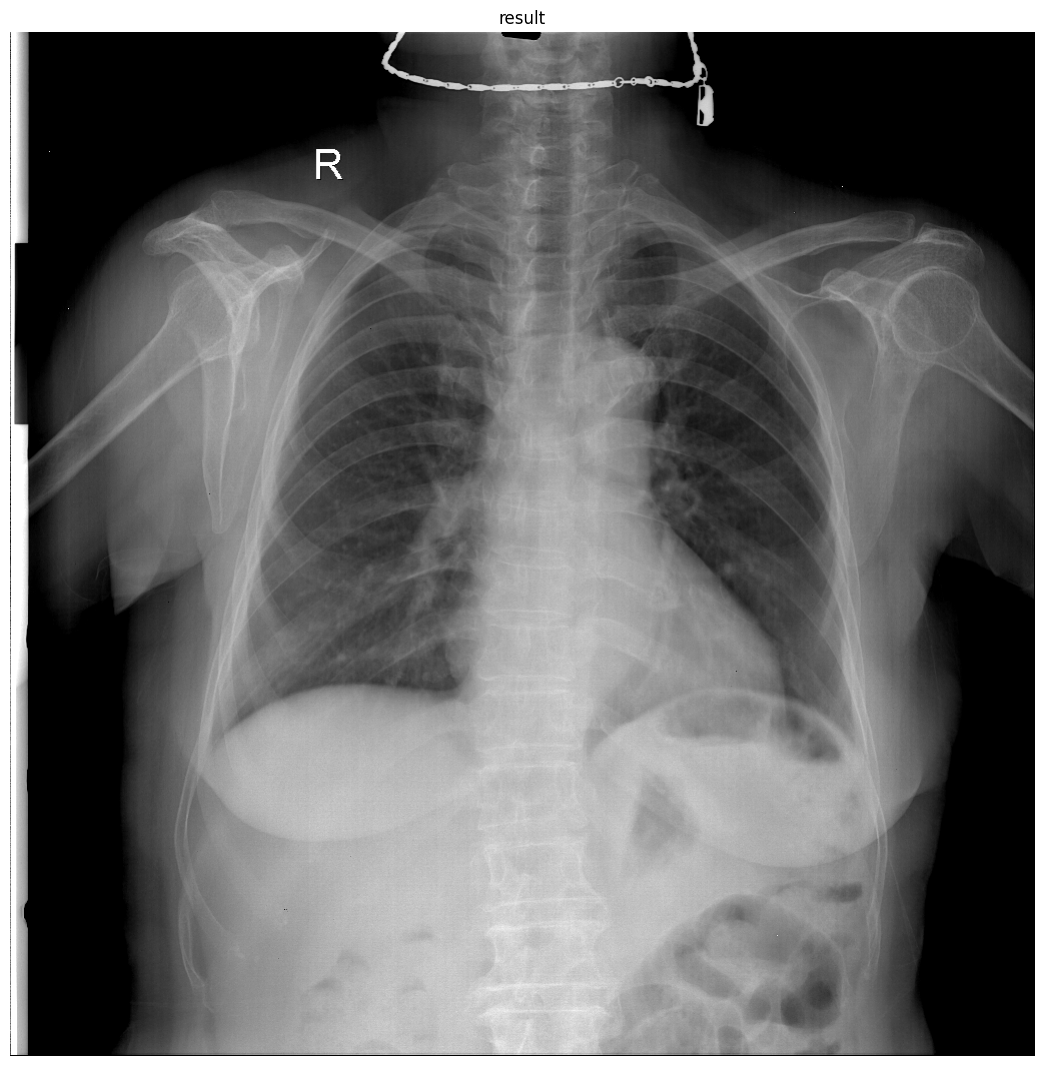

In [44]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


predictions의 길이는 4입니다. 이 4는 class의 개수를 의미하며
config에서 지정해준 순서대로, 즉 간단한 이름으로 01, 02, 04, 05를 나타냅니다.

따라서, 아래와 같은 경우 6개의 01 라벨과 5개의 05 라벨이 탐지되었다는 의미입니다.

하지만 위 사진을 보면 두 개만 시각화되었는데 11개의 탐지된 결과 중 기본 지정 threshold인 0.3을 넘는 데이터가 두 개 뿐이었기 때문입니다.

각 탐지된 결과는 5개의 element를 갖는데 앞의 4개가 bbox 좌표(x_min, y_min, x_max, y_max), 마지막 하나가 score(confidence)입니다.



In [ ]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

01 라벨의 스코어들을 보니 가장 첫 번째 탐지 결과만 살아남아 시각화된 걸 알 수 있습니다.

모든 테스트 데이터에 대해 추론을 진행합니다.

In [45]:
test_df= pd.read_csv('/home/ubuntu/mmdet1024/input/test.csv')

In [46]:
test_df

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,2642,3170
2996,c97e54a78bab9c05ce2e04fe6c284bcd,3072,3072
2997,33218cf183c1224a74ccfb514e827e15,2336,2836
2998,04b700c4815f088728db9f093c739707,2484,3064


In [47]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [48]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.4 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
        
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)

    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        
        # 512절대좌표
        boxes = boxes[indexes]


        # 512 상대좌표
        boxes_relative=boxes/512.0
        
        # test 해상도 width, height
        test = test_df[test_df['image_id'] == image_id]
        test_width = float(test['width'])
        test_height = float(test['height'])

        # xmin ymin xmax ymax
        # x * width
        # y * height
        for i,box in enumerate(boxes_relative):
            box[0] = float(box[0] * test_width)
            box[1] = float(box[1] * test_height) 
            box[2] = float(box[2] * test_width)
            box[3] = float(box[3] * test_height)

        # 최종 좌표
        boxes = boxes_relative
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [ ]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

In [ ]:
submission.head()

In [ ]:
submission.to_csv('/home/ubuntu/mmdet1024/output/mmdedtection_baseline.csv', index=False)